In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from multiprocessing import cpu_count
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from utils import to_absolute

In [3]:
data = pd.read_csv(Path.home()/'data'/'keypoints'/'training.csv')

In [4]:
data.shape

(7049, 31)

In [5]:
img_sz = 96
np_shape = img_sz, img_sz
torch_shape = 1, img_sz, img_sz
num_of_landmarks = 30
seed = 1

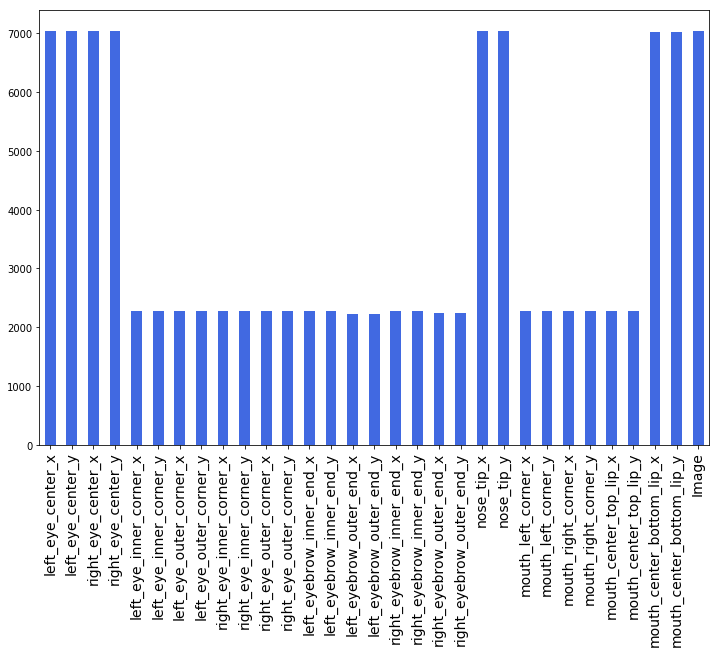

In [6]:
ax = data.count().plot.bar(color='royalblue', figsize=(12, 8))
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

In [7]:
def get(record, coord):
    return [v for k, v in record.items() if k.endswith(f'_{coord}')]

In [8]:
def create_sample(record, shape):
    return np.fromstring(record.Image, sep=' ').reshape(shape)

In [9]:
def create_target(record):
    xs, ys = [get(record, coord) for coord in ('x', 'y')]
    return np.r_[xs, ys]

In [10]:
def split(target):
    return target[:num_of_landmarks//2], target[num_of_landmarks//2:]

In [11]:
def show(df, i, ax=None, figsize=(4, 4)):
    record = df.iloc[i]
    sample = create_sample(record, np_shape)
    target = create_target(record)
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_title(f'#{i}')
    ax.imshow(sample, cmap='gray')
    ax.scatter(*split(target), color='lightgreen', edgecolor='white', alpha=0.8)
    ax.set_axis_off()

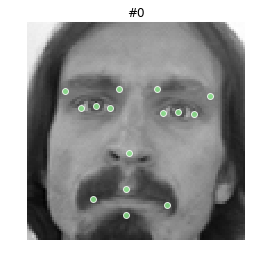

In [12]:
show(data, 0)

In [13]:
def show_random_grid(df, n=5, figsize=(10, 10), h_pad=0.05, w_pad=0.05):
    f, axes = plt.subplots(n, n, figsize=figsize)
    n_images = len(df)
    indexes = np.random.choice(n_images, size=n*n, replace=False)
    for idx, ax in zip(indexes, axes.flat):
        show(df, idx, ax=ax)
    f.tight_layout(h_pad=h_pad, w_pad=w_pad)

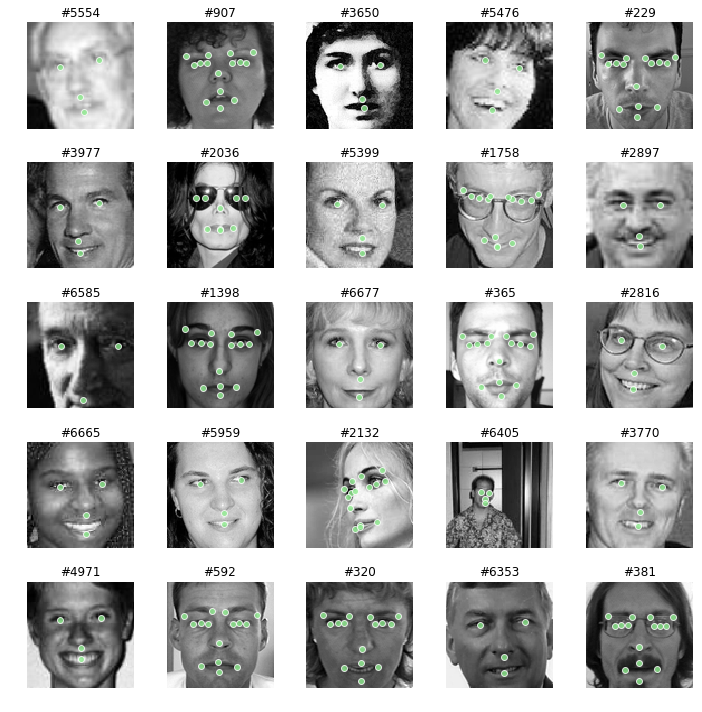

In [14]:
show_random_grid(data)

In [15]:
landmarks = data[data.columns[data.columns != 'Image']]

In [16]:
X = SimpleImputer().fit_transform(landmarks) 
imputed_data = pd.DataFrame(X, columns=landmarks.columns)
imputed_data['Image'] = data.Image

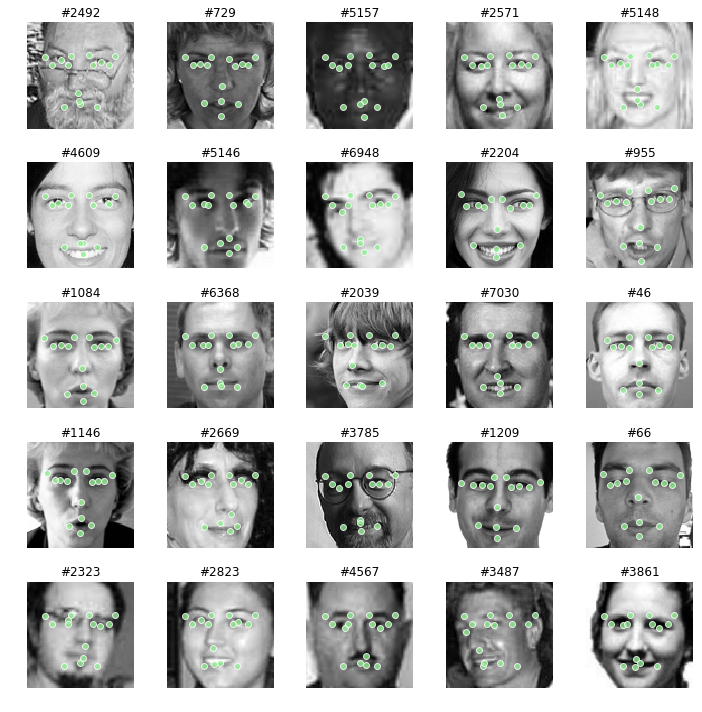

In [17]:
show_random_grid(imputed_data)

In [18]:
import copy
import math

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

from layers import conv, fc, res3x3, bottleneck, Flatten

In [19]:
X = np.stack(imputed_data.apply(lambda x: create_sample(x, torch_shape), axis=1).values)

In [20]:
y = np.stack(imputed_data.drop(columns='Image').apply(lambda x: create_target(x), axis=1).values)

In [21]:
def create_datasets(X, y, test_size=0.2):
    X_norm = X/255
    scaler = MinMaxScaler(feature_range=(-1, 1))
    y_norm = scaler.fit_transform(y)
    subsets = train_test_split(X_norm, y_norm, test_size=0.2, random_state=seed)
    X_train, X_test, y_train, y_test = [
        torch.tensor(subset, dtype=torch.float32) 
        for subset in subsets]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_test, y_test)
    return train_ds, valid_ds, scaler

In [22]:
def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl

In [23]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [24]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [25]:
class SimpleNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.conv1 = nn.Conv2d(ni, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, no)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.pool(x)
        x = self.fc(x.view(x.size(0), -1))
        return x

In [26]:
class ConvNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        layers  = conv(ni,  16, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += conv(16,  16, kernel=3, stride=1, pad=1, activ='leaky_relu', bn=True)
        layers += conv(16,  32, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += conv(32,  32, kernel=3, stride=1, pad=1, activ='leaky_relu', bn=True)
        layers += conv(32,  64, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += conv(64,  64, kernel=3, stride=1, pad=1, activ='leaky_relu', bn=True)
        layers += conv(64, 128, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += bottleneck()
        layers += fc(256, 128, bn=True, activ='relu')
        layers += fc(128, no, bn=False)
        self.model = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

In [27]:
class ResNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        layers = conv(ni, 32, kernel=3, stride=2, pad=1, activ='leaky_relu', bn=True)
        layers += [
            res3x3(3,  32,  32, activ='leaky_relu'),
            res3x3(3,  32,  64, activ='leaky_relu', upsample=True),
            res3x3(3,  64,  64, activ='leaky_relu'),
            res3x3(3,  64, 128, activ='leaky_relu', upsample=True),
            res3x3(3, 128, 128, activ='leaky_relu')]
        layers += bottleneck()
        layers += fc(256, 128, bn=True, activ='relu')
        layers += fc(128, no, bn=False)
        self.model = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

In [28]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [29]:
trn_ds, val_ds, scaler = create_datasets(X, y)

In [30]:
lr = 1e-2
wd = 1e-5
bs = 800
n_epochs = 100
patience = 20
no_improvements = 0
jobs = 12
best_loss = np.inf
best_weights = None
history = []
lr_history = []

trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=jobs)
dataset_sizes = {'train': len(trn_ds), 'val': len(val_ds)}

# net = SimpleNet(1, num_of_landmarks)
# net = ConvNet(1, num_of_landmarks)
net = ResNet(1, num_of_landmarks)
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = len(trn_dl)
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase, loader in (('train', trn_dl), ('val', val_dl)):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in loader:
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                torch.save(best_weights, 'best_weights.pth')
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

if best_weights is not None:
    print(f'Loading the best weights with the training loss: {best_loss:.4f}')
    net.load_state_dict(best_weights)

loss improvement on epoch: 1
[001/100] train: 1.9387 - val: 0.7841
loss improvement on epoch: 2
[002/100] train: 0.6358 - val: 0.5303
loss improvement on epoch: 3
[003/100] train: 0.5025 - val: 0.3882
loss improvement on epoch: 4
[004/100] train: 0.3253 - val: 0.3258
loss improvement on epoch: 5
[005/100] train: 0.3059 - val: 0.3124
loss improvement on epoch: 6
[006/100] train: 0.2701 - val: 0.2874
[007/100] train: 0.2653 - val: 0.2886
loss improvement on epoch: 8
[008/100] train: 0.2526 - val: 0.2756
[009/100] train: 0.2511 - val: 0.2799
loss improvement on epoch: 10
[010/100] train: 0.2456 - val: 0.2678
[011/100] train: 0.2496 - val: 0.2839
[012/100] train: 0.2442 - val: 0.2681
[013/100] train: 0.2412 - val: 0.2741
loss improvement on epoch: 14
[014/100] train: 0.2389 - val: 0.2640
[015/100] train: 0.2399 - val: 0.2653
loss improvement on epoch: 16
[016/100] train: 0.2329 - val: 0.2599
[017/100] train: 0.2321 - val: 0.2631
loss improvement on epoch: 18
[018/100] train: 0.2310 - val: 

In [31]:
net = ResNet(1, num_of_landmarks).to(device)
net.load_state_dict(torch.load('best_weights.pth'))

In [32]:
def np_clone(t):
    return t.clone().detach().cpu().numpy()

In [33]:
def predict(model, dataset, i, img_sz=img_sz, device=device, scaler=scaler):
    test_img, test_pts = dataset[i]
    model.train(False)
    [pred] = model(test_img[None].to(device))
    model.train(True)
    np_pts = np_clone(pred)
    np_pts = scaler.inverse_transform(np_pts.reshape(1, -1)).flatten()
    np_img = np_clone(test_img).transpose(1, 2, 0).reshape(96, 96)
    np_img *= 255
    np_img = np_img.astype(np.uint8)
    rescaled_test_pts = scaler.inverse_transform(test_pts.reshape(1, -1)).flatten()
    return np_pts, (np_img, rescaled_test_pts)

In [34]:
def show_predictions(model, dataset, n, figsize=(10, 10)):
    f, axes = plt.subplots(n, n, figsize=figsize)
    n_samples = len(dataset)
    indexes = np.random.choice(n_samples, size=n*n, replace=False)
    for ax, idx in zip(axes.flat, indexes):
        pred_pts, (test_img, test_pts) = predict(model, dataset, idx)
        ax.imshow(test_img, cmap='gray')
        ax.scatter(*split(test_pts), color='lightgreen', edgecolor='white', s=50, alpha=0.8, 
                   label='gt')
        ax.scatter(*split(pred_pts), color='red', marker='x', s=20, label='predicted')
        ax.set_axis_off()
    handles, labels = axes.flat[0].get_legend_handles_labels()
    f.legend(handles, labels, loc='upper center', fontsize=16)
    f.suptitle

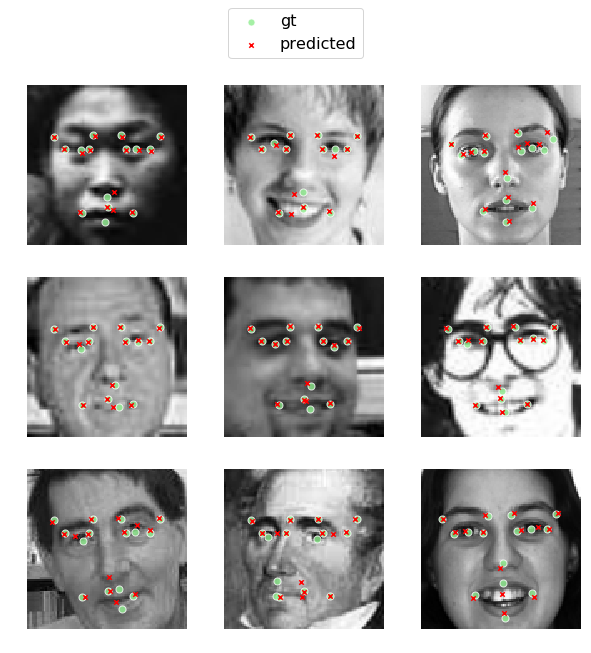

In [35]:
show_predictions(net, val_ds, 3)

In [36]:
def generate_patch(x, y, w, h, image):
    c = image.size(0)
    patch = torch.zeros((c, h, w), dtype=image.dtype)
    for q in range(h):
        for p in range(w):
            yq = y + q - (h - 1)/2
            xp = x + p - (w - 1)/2
            xd = 1 - (xp - math.floor(xp))
            xu = 1 - (math.ceil(xp) - xp)
            yd = 1 - (yq - math.floor(yq))
            yu = 1 - (math.ceil(yq) - yq)
            for idx in range(c):
                patch[idx, q, p] = (
                    image[idx, math.floor(yq), math.floor(xp)]*yd*xd + 
                    image[idx, math.floor(yq),  math.ceil(xp)]*yd*xu +
                    image[idx,  math.ceil(yq), math.floor(xp)]*yu*xd +
                    image[idx,  math.ceil(yq),  math.ceil(xp)]*yu*xu
                ).item()
    return patch

In [37]:
def generate_patches(image, points, n=None, sz=31):
    if n is None:
        n = len(points)//2
    patches = []
    for i in range(n):
        x_val, y_val = points[i], points[i + n]
        patch = generate_patch(x_val, y_val, sz, sz, image)
        patches.append(patch)
    return patches

In [38]:
def show_tensors(images, cols=4, figsize=(10, 10)):
    n = len(images)
    rows = int(math.ceil(n/cols))
    f, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax in axes.flat:
        ax.set_axis_off()
    for ax, image in zip(axes.flat, images):
        image = np_clone(image).transpose(1, 2, 0).squeeze()
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)

In [39]:
img, pts = torch.tensor(X[0]), y[0]

In [40]:
patches = generate_patches(img, pts, sz=16)

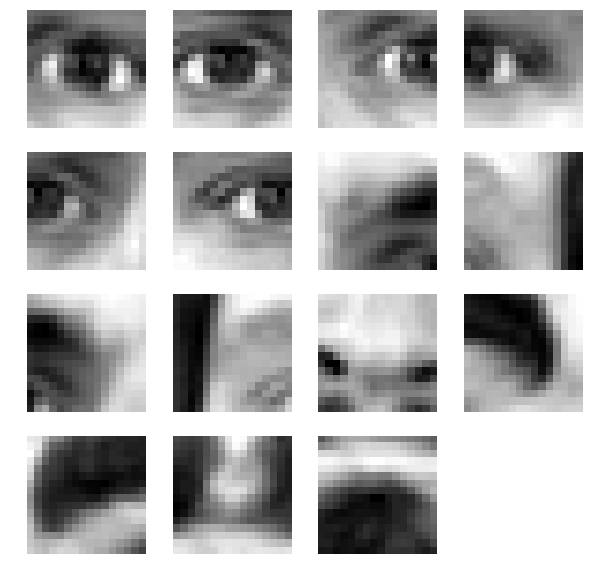

In [41]:
show_tensors(patches)

In [42]:
def generate_patches(image, points, sz=16):
    n = len(points)//2
    h, w = image.shape[-2:]
    xs, ys = to_absolute(points[:n], points[n:], w, h)
    patches = []
    for i in range(n):
        x, y = int(xs[i]), int(ys[i])
        patch = image[:, y-sz//2:y+sz//2, x-sz//2:x+sz//2]
#         if patch.size() != (1, sz, sz):
#             breakpoint()
        patches.append(patch)
    return patches

In [43]:
class ResidualModel(nn.Module):
    def __init__(self, n_landmarks, patch_size):
        super().__init__()
        self.patch_size = patch_size
        # should this be (n x 15), stacked patches?
        layers  = conv(n_landmarks//2, 16, 6, stride=2, bn=True, activ='relu')
        layers += conv(16, 16, 3, stride=1, bn=True, activ='relu')
        layers += [Flatten()]
        layers += fc(256, 128, bn=True, activ='relu')
        layers += fc(128, n_landmarks, bn=False)
        self.layers = nn.ModuleList(layers)
    
    def forward(self, s, x):
        s.clamp_(-0.95, 0.95)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        stacked = []
        for t1, t2 in zip(x, s):
            patches = [p for p in generate_patches(t1, t2, sz=self.patch_size)]
            sample = torch.cat(patches, dim=0).unsqueeze(0)
            stacked.append(sample)
        t = torch.cat(stacked, dim=0)
        for layer in self.layers:
            t = layer(t)
        return t

In [44]:
class LandmarksRegressor(nn.Module):
    def __init__(self, n_landmarks, s0_model, patch_size=16):
        super().__init__()
        self.s0_model = s0_model
        self.r1 = ResidualModel(n_landmarks, patch_size)
        self.r2 = ResidualModel(n_landmarks, patch_size)
        self.r3 = ResidualModel(n_landmarks, patch_size)
        self.s0_model.train(False)
    
    def forward(self, face_image):
        init = self.s0_model(face_image)
        adjusted = self.r1(init, face_image)
        adjusted = self.r2(adjusted, face_image)
        adjusted = self.r3(adjusted, face_image)
        return adjusted

In [45]:
device = torch.device('cuda:1')

In [46]:
lr = 1e-2
wd = 1e-5
bs = 800
n_epochs = 100
patience = 20
no_improvements = 0
jobs = 12
best_loss = np.inf
best_weights = None
history = []
lr_history = []

trn_ds, val_ds, scaler = create_datasets(X, y)
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=jobs)
dataset_sizes = {'train': len(trn_ds), 'val': len(val_ds)}

reg = LandmarksRegressor(num_of_landmarks, net).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(reg.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = len(trn_dl)
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase, loader in (('train', trn_dl), ('val', val_dl)):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in loader:
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = reg(x_batch)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(reg.state_dict())
                torch.save(best_weights, 'best_reg_weights.pth')
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

if best_weights is not None:
    print(f'Loading the best weights with the training loss: {best_loss:.4f}')
    reg.load_state_dict(best_weights)

loss improvement on epoch: 1
[001/100] train: 1.7633 - val: 0.7732
loss improvement on epoch: 2
[002/100] train: 0.5916 - val: 0.4744
[003/100] train: 0.5142 - val: 0.4815
loss improvement on epoch: 4
[004/100] train: 0.4062 - val: 0.3810
[005/100] train: 0.3552 - val: 0.3848
loss improvement on epoch: 6
[006/100] train: 0.3238 - val: 0.3179
[007/100] train: 0.2968 - val: 0.3298
loss improvement on epoch: 8
[008/100] train: 0.2837 - val: 0.2936
[009/100] train: 0.2737 - val: 0.3122
loss improvement on epoch: 10
[010/100] train: 0.2658 - val: 0.2819
[011/100] train: 0.2701 - val: 0.3033
loss improvement on epoch: 12
[012/100] train: 0.2590 - val: 0.2746
[013/100] train: 0.2564 - val: 0.2849
loss improvement on epoch: 14
[014/100] train: 0.2492 - val: 0.2728
[015/100] train: 0.2505 - val: 0.2808
loss improvement on epoch: 16
[016/100] train: 0.2479 - val: 0.2695
[017/100] train: 0.2488 - val: 0.2770
loss improvement on epoch: 18
[018/100] train: 0.2450 - val: 0.2693
[019/100] train: 0.24